# АВ тест

In [1]:
import pandas as pd

In [2]:
historical_data = pd.read_csv('investigate_window.csv', parse_dates = [1,2], index_col = 0)

In [3]:
historical_data.head()

,user_id,main_page_viewed_at,order_completed_at,time_to_order
0,959238,2020-11-20 23:55:02.759000+00:00,2020-11-30 02:22:32.759000+00:00,9.102431
1,337366,2020-12-05 23:41:42.244000+00:00,2020-12-12 22:25:52.244000+00:00,6.947338
2,259956,2020-11-20 23:33:53.269000+00:00,2020-11-25 13:08:03.269000+00:00,4.565394
3,534280,2020-11-28 23:44:56.556000+00:00,2020-12-05 10:14:06.556000+00:00,6.436921
4,795121,2020-11-18 23:59:56.236000+00:00,2020-11-27 02:38:16.236000+00:00,8.109954


In [4]:
historical_data.dtypes

user_id                             object
main_page_viewed_at    datetime64[ns, UTC]
order_completed_at                  object
time_to_order                      float64
dtype: object

**95, 90 и 85 перцентили.**

In [5]:
import numpy as np

In [6]:
perc_85 = round(np.percentile(historical_data['time_to_order'], 85), 1)
perc_90 = round(np.percentile(historical_data['time_to_order'], 90), 1)
perc_95 = round(np.percentile(historical_data['time_to_order'], 95), 1)
print('Перцентиль 85%:',perc_85,'\nПерцентиль 90%:',perc_90,'\nПерцентиль 95%:', perc_95)

Перцентиль 85%: 2.0 
Перцентиль 90%: 2.9 
Перцентиль 95%: 7.1


In [7]:
import seaborn as sns 
import matplotlib.pyplot as plt

<Figure size 1600x900 with 0 Axes>

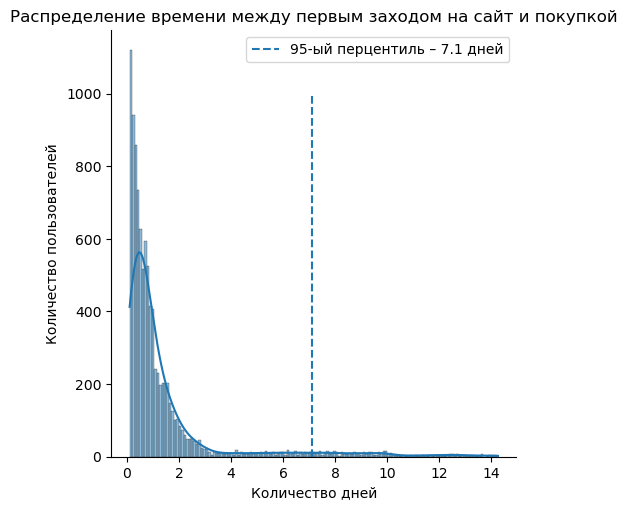

In [8]:
plt.figure(figsize=(16,9))
sns.displot(historical_data['time_to_order'], kde = True)
plt.vlines(perc_95, ymin = 0, ymax = 1000, linestyles = 'dashed', label = f'95-ый перцентиль – {perc_95} дней')
plt.title('Распределение времени между первым заходом на сайт и покупкой')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

## Распределение пользователей по группам по основным сегментам 

In [9]:
data = pd.read_csv('bakery_ab_test.csv', index_col = 0)
data

,user_id,test_group,purchase_amount,geo_group,acquisition_channel,within_window,platform
1,3738,test,306.639511,regions,target_direct,1,pc
2,3755,control,NaN,regions,target_direct,0,pc
3,3772,test,NaN,regions,context_brand,0,mobile
4,3789,control,NaN,spb,target_direct,0,pc
5,3806,test,NaN,regions,social_media,0,pc
...,...,...,...,...,...,...,...
152995,2604636,test,NaN,regions,target_direct,0,pc
152996,2604653,control,5236.818309,regions,organic,1,mobile
152997,2604670,control,NaN,regions,target_direct,0,pc
152998,2604687,control,101.783032,regions,target_direct,1,pc


In [10]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = df.groupby(by = [test_factor, segment])['user_id'].count().reset_index()
        sns.catplot(x = segment, 
                    y = 'user_id', 
                    hue = test_factor,
                    data = aggregated_data, 
                    kind = "bar", 
                    height = 4,
                    aspect = 1.5)

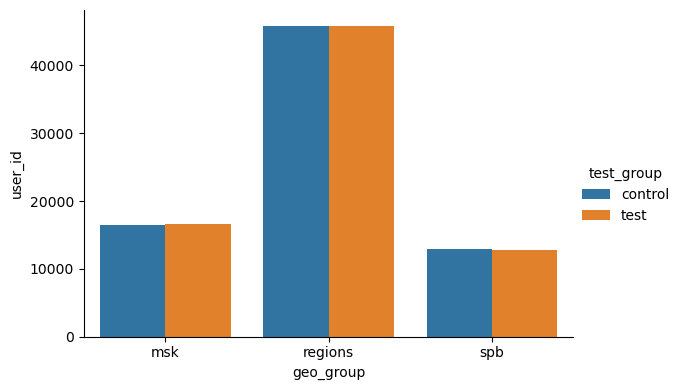

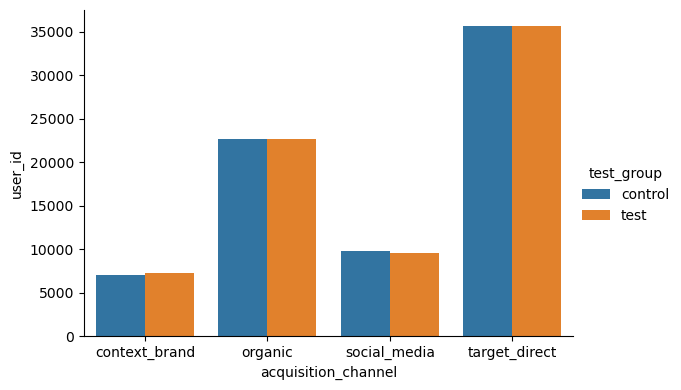

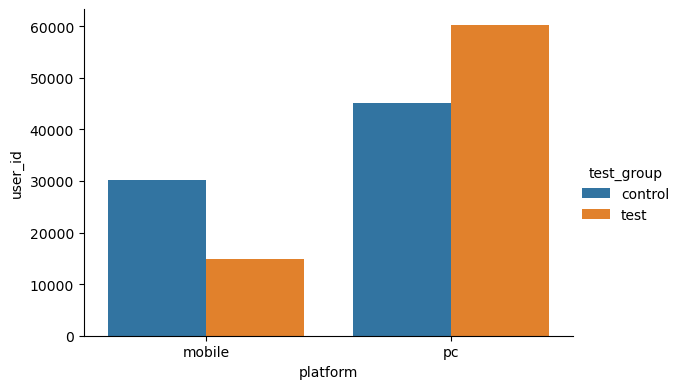

In [11]:
plot_segments_distribution(data,['geo_group','acquisition_channel', 'platform'],'test_group')

Вывод: сплитование по платформам неравномерно.

## Критерий Хи-квадрат для конверсии


In [12]:
metrics = data.groupby('test_group', as_index= False).agg({'user_id': 'count', 'within_window':'sum', 'purchase_amount': 'mean'})
metrics['conversion'] =  round(metrics['within_window'] / metrics['user_id']*100, 2)
metrics

,test_group,user_id,within_window,purchase_amount,conversion
0,control,75210,22998,5170.864335,30.58
1,test,75273,24427,5394.771589,32.45


In [13]:
metrics_pc = data.loc[data['platform'] == 'pc'].groupby('test_group', as_index= False).agg({'user_id': 'count', 'within_window':'sum', 'purchase_amount': 'mean'})
metrics_pc['conversion'] =  round(metrics_pc['within_window'] / metrics_pc['user_id']*100, 2)
metrics_pc

,test_group,user_id,within_window,purchase_amount,conversion
0,control,45112,13732,5200.121803,30.44
1,test,60317,19659,5401.003720,32.59


In [14]:
metrics_mobile = data.loc[data['platform'] == 'mobile'].groupby('test_group', as_index= False).agg({'user_id': 'count', 'within_window':'sum', 'purchase_amount': 'mean'})
metrics_mobile['conversion'] =  round(metrics_mobile['within_window'] / metrics_mobile['user_id']*100, 2)
metrics_mobile

,test_group,user_id,within_window,purchase_amount,conversion
0,control,30098,9266,5127.505438,30.79
1,test,14956,4768,5369.075812,31.88


**p-value для каждой группы с помощью теста хи-квадрат**

In [15]:
import statsmodels.stats.proportion as proportion

In [16]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['within_window'], metrics['user_id'])
print(pval)

5.321539863368111e-15


In [17]:
chi2stat_pc, pval_pc, table_pc = proportion.proportions_chisquare(metrics_pc['within_window'], metrics_pc['user_id'])
print(pval_pc)

1.0436637877855105e-13


In [18]:
chi2stat_mobile, pval_mobile, table_mobile = proportion.proportions_chisquare(metrics_mobile['within_window'], metrics_mobile['user_id'])
print(pval_mobile)

0.018202784051985058


**Анализ уровень значимости в 5% с помощью переменной**

In [19]:
alpha = 0.05
print(pval < alpha)
print(pval_pc < alpha)
print(pval_mobile < alpha)

True
True
True


Вывод: значения тестов статистически значимы

## Мощность теста

In [20]:
import statsmodels.stats.power as smp

In [21]:
chipower = smp.GofChisquarePower()

In [22]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

In [23]:
conversion_control = metrics['conversion'].values[0]/100 
conversion_test = metrics['conversion'].values[1]/100
nobs = min(metrics['user_id'])

In [24]:
conversion_control_mobile = metrics_mobile['conversion'].values[0]/100 
conversion_test_mobile = metrics_mobile['conversion'].values[1]/100
nobs_mobile = min(metrics_mobile['user_id'])

In [25]:
conversion_control_pc = metrics_pc['conversion'].values[0]/100 
conversion_test_pc = metrics_pc['conversion'].values[1]/100
nobs_pc = min(metrics_pc['user_id'])

  **Анализ мощности для каждого сегмента, для которого делали тест хи-квадрат.**

In [26]:
power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test),
                                               nobs = nobs,
                                               alpha = pval,
                                               power = None)
power

0.927136791608663

In [27]:
mobile_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_mobile, conversion_test_mobile),
                                               nobs = nobs_mobile,
                                               alpha = pval_mobile,
                                               power = None)
mobile_power

0.51629109023244

In [28]:
pc_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_pc, conversion_test_pc),
                                               nobs = nobs_pc,
                                               alpha = pval_pc,
                                               power = None)
pc_power

0.7999771197445285

Вывод: В общем мощности достаточно чтобы заметить разницу, но в сплите mobile с вероятностью выше 38% мы бы не увидели статистически значимых отличий там, где они существуют.

## Бутстрап для оценки влияния теста на средний чек

In [29]:
!pip install bootstrapped
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import numpy as np

In [30]:
test = data[data['test_group'] == 'test']['purchase_amount'].dropna().values
control = data[data['test_group'] == 'control']['purchase_amount'].dropna().values

test_pc = data[data['test_group'] == 'test']['purchase_amount'].loc[data['platform'] == 'pc'].dropna().values
control_pc = data[data['test_group'] == 'control']['purchase_amount'].loc[data['platform'] == 'pc'].dropna().values

test_mobile = data[data['test_group'] == 'test']['purchase_amount'].loc[data['platform'] == 'mobile'].dropna().values
control_mobile = data[data['test_group'] == 'control']['purchase_amount'].loc[data['platform'] == 'mobile'].dropna().values

In [31]:
boot = bs.bootstrap_ab(test = test, ctrl = control
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)

In [32]:
boot_pc = bs.bootstrap_ab(test = test_pc, ctrl = control_pc
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)

In [33]:
boot_mobile = bs.bootstrap_ab(test = test_mobile, ctrl = control_mobile
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)

**Размер доверительного интервала для каждого исследуемого сегмента 95% с помощью перцентилей**

In [34]:
borders = np.percentile(boot, [2.5, 97.5])
borders_pc = np.percentile(boot_pc, [2.5, 97.5])
borders_mobile = np.percentile(boot_mobile, [2.5, 97.5])

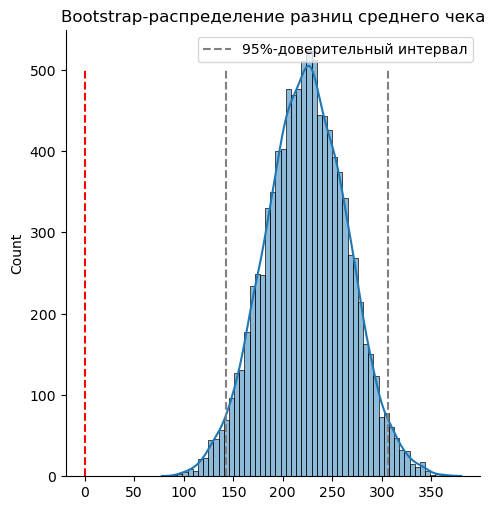

In [35]:
sns.displot(boot, kde = True)
plt.title('Bootstrap-распределение разниц среднего чека')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, ymin = 0, ymax = 500, linestyles= '--', colors = 'red')
plt.vlines(borders,ymin = 0, ymax = 500, linestyles= '--', colors = 'grey', label = '95%-доверительный интервал')
plt.legend()
plt.show()

**Статистически значимое изменение по среднему чеку в каждом сегменте**
   

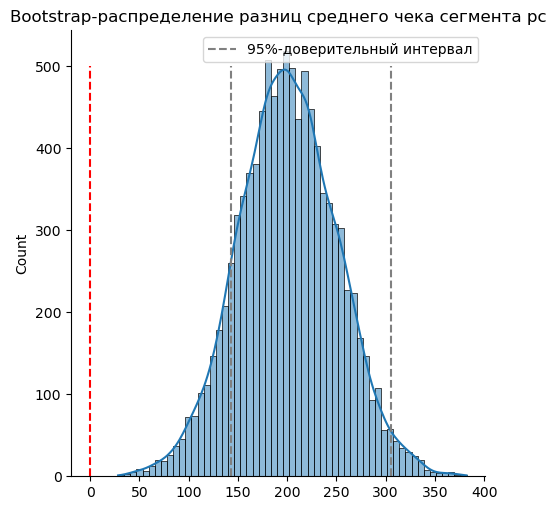

In [36]:
sns.displot(boot_pc, kde = True)
plt.title('Bootstrap-распределение разниц среднего чека сегмента pc')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, ymin = 0, ymax = 500, linestyles= '--', colors = 'red')
plt.vlines(borders,ymin = 0, ymax = 500, linestyles= '--', colors = 'grey', label = '95%-доверительный интервал')
plt.legend()
plt.show()

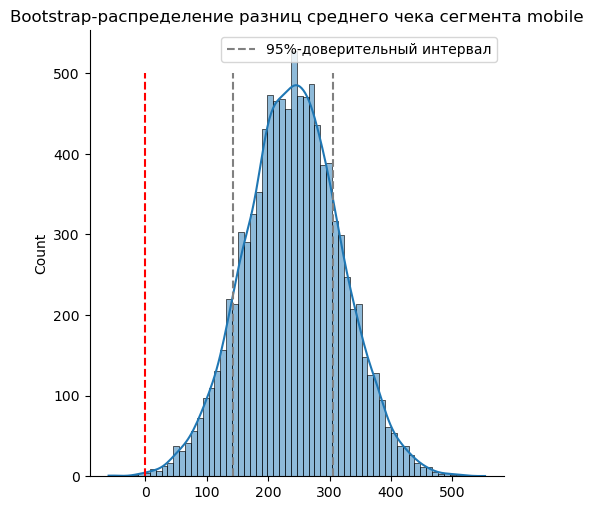

In [37]:
sns.displot(boot_mobile, kde = True)
plt.title('Bootstrap-распределение разниц среднего чека сегмента mobile')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, ymin = 0, ymax = 500, linestyles= '--', colors = 'red')
plt.vlines(borders,ymin = 0, ymax = 500, linestyles= '--', colors = 'grey', label = '95%-доверительный интервал')
plt.legend()
plt.show()

Вывод: статистически значимая разница в чеках наблюдается.

Вывод: Внедрять изменения нужно, хоть и сплитование по платформам неравномерно и в сплите mobile недостаточная мощность, статистически значимая разница была выявлена во всех тестах.